In [109]:
def generate_face_correspondences(theImage1, theImage2):
    # Detect the points of face.
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    corresp = np.zeros((68,2))

    imgList = [theImage1,theImage2]
    list1 = []
    list2 = []
    j = 1

    for img in imgList:

        size = (img.shape[0],img.shape[1])
        if(j == 1):
            currList = list1
        else:
            currList = list2

        # Ask the detector to find the bounding boxes of each face. The 1 in the
        # second argument indicates that we should upsample the image 1 time. This
        # will make everything bigger and allow us to detect more faces.

        dets = detector(img, 1)

        try:
            if len(dets) == 0:
                raise NoFaceFound
        except NoFaceFound:
            print("Sorry, but I couldn't find a face in the image.")

        j=j+1

        for k, rect in enumerate(dets):
            
            # Get the landmarks/parts for the face in rect.
            shape = predictor(img, rect)
            # corresp = face_utils.shape_to_np(shape)
            
            for i in range(0,68):
                x = shape.part(i).x
                y = shape.part(i).y
                currList.append((x, y))
                corresp[i][0] += x
                corresp[i][1] += y
                # cv2.circle(img, (x, y), 2, (0, 255, 0), 2)

            # Add back the background
            currList.append((1,1))
            currList.append((size[1]-1,1))
            currList.append(((size[1]-1)//2,1))
            currList.append((1,size[0]-1))
            currList.append((1,(size[0]-1)//2))
            currList.append(((size[1]-1)//2,size[0]-1))
            currList.append((size[1]-1,size[0]-1))
            currList.append(((size[1]-1)//2,(size[0]-1)//2))

#         cv2.imwrite("test.png", img)

    # Add back the background
    narray = corresp/2
    narray = np.append(narray,[[1,1]],axis=0)
    narray = np.append(narray,[[size[1]-1,1]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,1]],axis=0)
    narray = np.append(narray,[[1,size[0]-1]],axis=0)
    narray = np.append(narray,[[1,(size[0]-1)//2]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,size[0]-1]],axis=0)
    narray = np.append(narray,[[size[1]-1,size[0]-1]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,(size[0]-1)//2]],axis=0)
    
    return [size,imgList[0],imgList[1],list1,list2,narray]

In [110]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

In [111]:
image1 = cv2.imread('res21_near.jpeg')
image2 = cv2.imread('res22_far.jpeg')

In [112]:
image1.shape,image2.shape

((353, 360, 3), (353, 360, 3))

In [113]:
[size, img1, img2, points1, points2, list3] = generate_face_correspondences(image1, image2)

In [136]:
# points1
a_file = open("points1.txt", "w")
for row in points1:
    np.savetxt(a_file, row)

a_file.close()

a_file = open("points2.txt", "w")
for row in points2:
    np.savetxt(a_file, row)

a_file.close()

In [171]:
# (points1+points2)/2


In [151]:
original_array = np.loadtxt("points1.txt").reshape(76, 2)




original_array = np.int64(original_array)
points1 = original_array.tolist()

original_array = np.loadtxt("points2.txt").reshape(76, 2)
original_array = np.int64(original_array)
points2 = original_array.tolist()

In [172]:
list3 = points1.copy()
np.array(points1[0])+np.array(points1[1])
for i in range(len(points1)):
    temp = (np.array(points1[i])+np.array(points2[i]))/2
    
    list3[i] = temp.tolist()

list3 = np.array(list3)
# list3

In [152]:
img1_test1 = img1.copy()
img2_test1 = img2.copy()

In [153]:
for item in points2:
    img2_test1[item[1],item[0]] = [255,0,0]

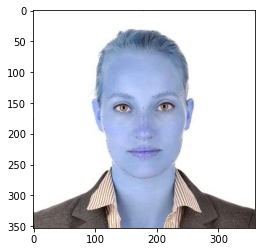

In [154]:
plt.imshow(img2_test1)

In [102]:
import cv2
import numpy as np
import random

# Check if a point is inside a rectangle
def rect_contains(rect, point):

    if point[0] < rect[0]:
        return False
    elif point[1] < rect[1]:
        return False
    elif point[0] > rect[2]:
        return False
    elif point[1] > rect[3]:
        return False
    return True

# Write the delaunay triangles into a file
def draw_delaunay(f_w, f_h, subdiv, dictionary1):

    list4 = []

    triangleList = subdiv.getTriangleList()
    r = (0, 0, f_w, f_h)

    for t in triangleList :
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))

        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            list4.append((dictionary1[pt1],dictionary1[pt2],dictionary1[pt3]))

    dictionary1 = {}
    return list4

def make_delaunay(f_w, f_h, theList, img1, img2):

    # Make a rectangle.
    rect = (0, 0, f_w, f_h)

    # Create an instance of Subdiv2D.
    subdiv = cv2.Subdiv2D(rect)

    # Make a points list and a searchable dictionary. 
    theList = theList.tolist()
    points = [(int(x[0]),int(x[1])) for x in theList]
    dictionary = {x[0]:x[1] for x in list(zip(points, range(76)))}
    
    # Insert points into subdiv
    for p in points :
        subdiv.insert(p)

    # Make a delaunay triangulation list.
    list4 = draw_delaunay(f_w, f_h, subdiv, dictionary)
   
    # Return the list.
    return list4

In [103]:
def apply_affine_transform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    return dst

In [131]:
import imageio

In [176]:
original_array = np.loadtxt("points1.txt").reshape(76, 2)




original_array = np.int64(original_array)
points1 = original_array.tolist()

original_array = np.loadtxt("points2.txt").reshape(76, 2)
original_array = np.int64(original_array)
points2 = original_array.tolist()


list3 = points1.copy()
np.array(points1[0])+np.array(points1[1])
for i in range(len(points1)):
    temp = (np.array(points1[i])+np.array(points2[i]))/2
    
    list3[i] = temp.tolist()

list3 = np.array(list3)

img1 = cv2.imread('res01.jpeg')
img2 = cv2.imread('res02.jpeg')

size = (img1.shape[0],img1.shape[1])

In [177]:
tri = make_delaunay(size[1], size[0], list3, img1, img2)

In [185]:
# tri

In [187]:
len(tri)

143

In [190]:
num_images = int(45)
#     filenames = []
# for j in range(0, num_images):
#         filename = f'frame_{1}_{j}.png'
#         filenames.append(filename)

#         if (frame == n_frames):
#             for i in range(5):
#                 filenames.append(filename)
j = 0

img1 = np.float(img1)
img2 = np.float(img2)

# Read array of corresponding points
points = []
alpha = j/(num_images-1)

# Compute weighted average point coordinates
for i in range(0, len(points1)):
    x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
    y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
    points.append((x,y))

# Allocate space for final output
morphed_frame = np.zeros(img1.shape, dtype = img1.dtype)

for i in range(len(tri)):    
    x = int(tri[i][0])
    y = int(tri[i][1])
    z = int(tri[i][2])

    t1 = [points1[x], points1[y], points1[z]]
    t2 = [points2[x], points2[y], points2[z]]
    t = [points[x], points[y], points[z]]



In [248]:
points = []
alpha = j/(num_images-1)

# Compute weighted average point coordinates
for i in range(len(points1)):
    points.append(((1 - alpha) * points1[i][0] + alpha * points2[i][0],(1 - alpha) * points1[i][1] + alpha * points2[i][1]))

In [4]:
# morphed_frame = np.zeros(img1.shape, dtype = img1.dtype)
# morphed_frame = np.zeros_like(img1)
# morphed_frame

In [197]:
i = 10
x = int(tri[i][0])
y = int(tri[i][1])
z = int(tri[i][2])

t1 = [points1[x], points1[y], points1[z]]
t2 = [points2[x], points2[y], points2[z]]
t = [points[x], points[y], points[z]]

In [198]:
t1,t2,t

([[119, 189], [114, 171], [142, 165]],
 [[115, 192], [111, 172], [140, 163]],
 [(119.0, 189.0), (114.0, 171.0), (142.0, 165.0)])

In [214]:
def bounds(t):
    t_1 = (t[0])
    t_2 = (t[1])
    t_3 = (t[2])
    min_x = np.int(np.min([t_1[0],t_3[0],t_2[0]]))
    min_y = np.int(np.min([t_1[1],t_3[1],t_2[1]]))
    max_x = np.int(np.max([t_1[0],t_3[0],t_2[0]]))
    max_y = np.int(np.max([t_1[1],t_3[1],t_2[1]]))
    w = max_x - min_x + 1
    h = max_y - min_y + 1
    return [min_x,min_y,w,h]

In [215]:
bounds(t)

[114, 165, 29, 25]

In [216]:

r1 = bounds(t1)
r2 = bounds(t2)
r = bounds(t)

t1_0 = []
t2_0 = []
t_0 = []

for k in range(3):

    t1_0.append(((t1[k][0] - r1[0]),(t1[k][1] - r1[1])))
    t2_0.append(((t2[k][0] - r2[0]),(t2[k][1] - r2[1])))
    t_0.append(((t[k][0] - r[0]),(t[k][1] - r[1])))


mask = np.zeros((r[3], r[2], 3), dtype = np.float64)
cv2.fillConvexPoly(mask, np.int32(t_0), (1.0, 1.0, 1.0), 16, 0)


img1_0 = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
img2_0 = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

size = (r[2], r[3])
warpImage1 = apply_affine_transform(img1_0, t1_0, t_0, size)
warpImage2 = apply_affine_transform(img2_0, t2_0, t_0, size)


imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2


frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask
    

In [217]:
r1,r2,r

([114, 165, 29, 25], [111, 163, 30, 30], [114, 165, 29, 25])

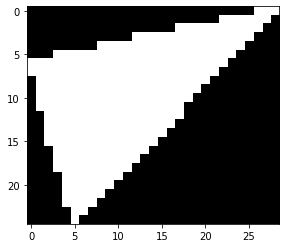

In [218]:
plt.imshow(mask)

In [236]:
num_images = int(45)
img1 = np.float64(image1)
img2 = np.float64(image2)


filenames = []
for frame in range(num_images):
    filename = f'frame_{1}_{frame}.png'
    filenames.append(filename)

    points = []
    alpha = frame/(num_images-1)


    for i in range(len(points1)):
        points.append(((1 - alpha) * points1[i][0] + alpha * points2[i][0],(1 - alpha) * points1[i][1] + alpha * points2[i][1]))


    frame_img = np.zeros_like(img1)

    for i in range(len(tri)):    

        t1 = [points1[int(tri[i][0])], points1[int(tri[i][1])], points1[int(tri[i][2])]]
        t2 = [points2[int(tri[i][0])], points2[int(tri[i][1])], points2[int(tri[i][2])]]
        t = [points[int(tri[i][0])], points[int(tri[i][1])], points[int(tri[i][2])]]

        r1 = bounds(t1)
        r2 = bounds(t2)
        r = bounds(t)


        t1_0 = []
        t2_0 = []
        t_0 = []

        for k in range(3):
            
            t1_0.append(((t1[k][0] - r1[0]),(t1[k][1] - r1[1])))
            t2_0.append(((t2[k][0] - r2[0]),(t2[k][1] - r2[1])))
            t_0.append(((t[k][0] - r[0]),(t[k][1] - r[1])))


        mask = np.zeros((r[3], r[2], 3), dtype = np.float64)
        cv2.fillConvexPoly(mask, np.int32(t_0), (1.0, 1.0, 1.0), 16, 0)
        

        img1_0 = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2_0 = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (r[2], r[3])
        warpImage1 = apply_affine_transform(img1_0, t1_0, t_0, size)
        warpImage2 = apply_affine_transform(img2_0, t2_0, t_0, size)


        imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2


        frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask
    
    res = (cv2.cvtColor(np.uint8(frame_img), cv2.COLOR_BGR2RGB))
    
    plt.imsave(filename,res)
    if frame == 14:
        plt.imsave('res03.jpg',res)
    if frame == 29:
        plt.imsave('res04.jpg',res)

with imageio.get_writer('morph.gif', mode='I') as writer:
    for filename in filenames:
        temp = imageio.imread(filename)
        writer.append_data(temp)
for filename in set(filenames):
    os.remove(filename)


In [237]:
num_images = int(45)
img1 = np.float64(image2)
img2 = np.float64(image1)
points1,points2 = points2,points1

filenames = []
for frame in range(0, num_images):
    filename = f'frame_{1}_{frame}.png'
    filenames.append(filename)

#         if (frame == n_frames):
#             for i in range(5):
#                 filenames.append(filename)
# j = 0


    points = []
    alpha = frame/(num_images-1)


    for i in range(len(points1)):
        points.append(((1 - alpha) * points1[i][0] + alpha * points2[i][0],(1 - alpha) * points1[i][1] + alpha * points2[i][1]))




    frame_img = np.zeros_like(img1)

    for i in range(len(tri)):    
        t1 = [points1[int(tri[i][0])], points1[int(tri[i][1])], points1[int(tri[i][2])]]
        t2 = [points2[int(tri[i][0])], points2[int(tri[i][1])], points2[int(tri[i][2])]]
        t = [points[int(tri[i][0])], points[int(tri[i][1])], points[int(tri[i][2])]]
        
        r1 = bounds(t1)
        r2 = bounds(t2)
        r = bounds(t)


        t1_0 = []
        t2_0 = []
        t_0 = []

        for k in range(3):
            
            t1_0.append(((t1[k][0] - r1[0]),(t1[k][1] - r1[1])))
            t2_0.append(((t2[k][0] - r2[0]),(t2[k][1] - r2[1])))
            t_0.append(((t[k][0] - r[0]),(t[k][1] - r[1])))


        mask = np.zeros((r[3], r[2], 3), dtype = np.float64)
        cv2.fillConvexPoly(mask, np.int32(t_0), (1.0, 1.0, 1.0), 16, 0)
        

        img1_0 = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2_0 = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (r[2], r[3])
        warpImage1 = apply_affine_transform(img1_0, t1_0, t_0, size)
        warpImage2 = apply_affine_transform(img2_0, t2_0, t_0, size)


        imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2


        frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask
    
    res = (cv2.cvtColor(np.uint8(frame_img), cv2.COLOR_BGR2RGB))
    
    plt.imsave(filename,res)
    if frame == 14:
        plt.imsave('res03.jpg',res)
    if frame == 29:
        plt.imsave('res04.jpg',res)

with imageio.get_writer('morph.gif', mode='I') as writer:
    for filename in filenames:
        temp = imageio.imread(filename)
        writer.append_data(temp)
for filename in set(filenames):
    os.remove(filename)



In [240]:
points1,points2 = points2,points1

In [241]:
num_images = int(45)
img1 = np.float32(image1)
img2 = np.float32(image2)


filenames = []
for frame in range(0, num_images):
    filename = f'frame_{1}_{frame}.png'
    filenames.append(filename)

#         if (frame == n_frames):
#             for i in range(5):
#                 filenames.append(filename)
# j = 0


    points = []
    alpha = frame/(num_images-1)

    for i in range(len(points1)):
        points.append(((1 - alpha) * points1[i][0] + alpha * points2[i][0],(1 - alpha) * points1[i][1] + alpha * points2[i][1]))



        
    frame_img = np.zeros(img1.shape, dtype = img1.dtype)

    for i in range(len(tri)):    
        t1 = [points1[int(tri[i][0])], points1[int(tri[i][1])], points1[int(tri[i][2])]]
        t2 = [points2[int(tri[i][0])], points2[int(tri[i][1])], points2[int(tri[i][2])]]
        t = [points[int(tri[i][0])], points[int(tri[i][1])], points[int(tri[i][2])]]

        r1 = bounds(t1)
        r2 = bounds(t2)
        r = bounds(t)

        t1_0 = []
        t2_0 = []
        t_0 = []

        for k in range(3):
            
            t1_0.append(((t1[k][0] - r1[0]),(t1[k][1] - r1[1])))
            t2_0.append(((t2[k][0] - r2[0]),(t2[k][1] - r2[1])))
            t_0.append(((t[k][0] - r[0]),(t[k][1] - r[1])))


        mask = np.zeros((r[3], r[2], 3), dtype = np.float64)
        cv2.fillConvexPoly(mask, np.int32(t_0), (1.0, 1.0, 1.0), 16, 0)
        

        img1_0 = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2_0 = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (r[2], r[3])
        warpImage1 = apply_affine_transform(img1_0, t1_0, t_0, size)
        warpImage2 = apply_affine_transform(img2_0, t2_0, t_0, size)


        imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2


        frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask
    
    res = (cv2.cvtColor(np.uint8(frame_img), cv2.COLOR_BGR2RGB))
    
    plt.imsave(filename,res)
    if frame == 14:
        plt.imsave('res03.jpg',res)
    if frame == 29:
        plt.imsave('res04.jpg',res)

img1 = np.float32(image2)
img2 = np.float32(image1)
points1,points2 = points2,points1

# filenames = []
for frame in range(num_images, num_images + num_images):
    filename = f'frame_{1}_{frame}.png'
    filenames.append(filename)

#         if (frame == n_frames):
#             for i in range(5):
#                 filenames.append(filename)
# j = 0



    points = []
    alpha = (frame-num_images)/(num_images-1)


    for i in range(len(points1)):
        points.append(((1 - alpha) * points1[i][0] + alpha * points2[i][0],(1 - alpha) * points1[i][1] + alpha * points2[i][1]))




    frame_img = np.zeros(img1.shape, dtype = img1.dtype)

    for i in range(len(tri)):    
        t1 = [points1[int(tri[i][0])], points1[int(tri[i][1])], points1[int(tri[i][2])]]
        t2 = [points2[int(tri[i][0])], points2[int(tri[i][1])], points2[int(tri[i][2])]]
        t = [points[int(tri[i][0])], points[int(tri[i][1])], points[int(tri[i][2])]]

        r1 = bounds(t1)
        r2 = bounds(t2)
        r = bounds(t)


        t1_0 = []
        t2_0 = []
        t_0 = []

        for k in range(0, 3):
            
            t1_0.append(((t1[k][0] - r1[0]),(t1[k][1] - r1[1])))
            t2_0.append(((t2[k][0] - r2[0]),(t2[k][1] - r2[1])))
            t_0.append(((t[k][0] - r[0]),(t[k][1] - r[1])))


        mask = np.zeros((r[3], r[2], 3), dtype = np.float64)
        cv2.fillConvexPoly(mask, np.int32(t_0), (1.0, 1.0, 1.0), 16, 0)
        

        img1_0 = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2_0 = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (r[2], r[3])
        warpImage1 = apply_affine_transform(img1_0, t1_0, t_0, size)
        warpImage2 = apply_affine_transform(img2_0, t2_0, t_0, size)


        imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2


        frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = frame_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask
    
    res = (cv2.cvtColor(np.uint8(frame_img), cv2.COLOR_BGR2RGB))
    
    plt.imsave(filename,res)
#     if frame == 14:
#         plt.imsave('res03.jpg',res)
#     if frame == 29:
#         plt.imsave('res04.jpg',res)

with imageio.get_writer('morph.gif', mode='I') as writer:
    for filename in filenames:
        temp = imageio.imread(filename)
        writer.append_data(temp)
for filename in set(filenames):
    os.remove(filename)

points1,points2 = points2,points1